In [1]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import ta
#from preprocesslib import preprocessEach, makeY

In [2]:
import os
import pandas as pd
import numpy as np

'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''

def preprocessEach(folder_name):
   # set file path
    # folder_path = f'/content/drive/MyDrive/research/data/{folder_name}_clean'
    folder_path = f'../data/{folder_name}_clean'


    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path, index_col=0)
        df.index = pd.to_datetime(df.index)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']


        df = df[['Close','Volume','Diff','open-close','MA5', 'Search']]
        df.fillna(0,inplace=True)



        #log transform
        df = np.log1p(df)
        # df.reset_index(inplace=True)
        df.fillna(0,inplace=True)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)
def makeY(folder_name, filelength):

    if folder_name=='growth':
        yGrowths = np.ones(filelength)
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yGrowths = np.zeros(filelength)
        yValues = np.ones(filelength)
    elif folder_name=='overlap':
        yGrowths = np.ones(filelength)
        yValues = np.ones(filelength)

    y = np.column_stack([yGrowths.T, yValues.T])
    return y

In [3]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

In [4]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [5]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
yOverlaps = makeY('overlap', n_samples)

In [6]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [7]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [8]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    np.random.seed(2023)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [9]:
#cross validation
X_train, X_test, Y_train, Y_test = splitData(x,y)

In [10]:
growth_Y_test = Y_test[:,0]
value_Y_test = Y_test[:,1]

In [11]:
# model_encoder=load_model('./dimensionReduction.h5')
# X_test_encoded = model_encoder.predict(X_test)

In [12]:
def predictLabelForGivenThreshold(threshold, pred):
  y_pred=[]
  for sample in  pred:
    y_pred.append([1. if i>=threshold else 0. for i in sample ] )
  return np.array(y_pred)

In [13]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [14]:
growth_model = load_model('./best_model_growth_softmax_6f_bootx.h5')
growth_pred = growth_model.predict(X_test)
growth_pred = growth_pred[:,0].reshape(-1,1)


Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-06-04 00:37:13.618226: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 1s 46ms/step


In [29]:
value_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 1248, 64)          13824     
                                                                 
 dropout_4 (Dropout)         (None, 1248, 64)          0         
                                                                 
 gru_9 (GRU)                 (None, 16)                3936      
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 17,794
Trainable params: 17,794
Non-trainable params: 0
_________________________________________________________________


In [15]:
value_model=load_model('./best_model_value_6f.h5')
value_pred = value_model.predict(X_test)

21/21 [==============================] - 1s 45ms/step


In [16]:
value_pred = value_pred[:,1].reshape(-1,1)

In [17]:
np.set_printoptions(precision=6, suppress=True)

In [18]:
growth_pred_pre = predictLabelForGivenThreshold(0.5, growth_pred)
value_pred_pre = predictLabelForGivenThreshold(0.5, value_pred)
Y_pred_per = np.concatenate([growth_pred,value_pred], axis=1)
Y_pred = np.concatenate([growth_pred_pre,value_pred_pre], axis=1)



In [19]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test, Y_pred)

array([[[124, 103],
        [ 67, 349]],

       [[170,  39],
        [132, 302]]])

In [21]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, Y_pred))
print(accuracy_score(Y_test[:,0], Y_pred[:,0]))
print(accuracy_score(Y_test[:,1], Y_pred[:,1]))



0.567651632970451
0.7356143079315708
0.7340590979782271


In [22]:
from sklearn.metrics import classification_report
label_names = ['Growth', 'Value']
print(classification_report(Y_test, Y_pred, target_names=label_names))

              precision    recall  f1-score   support

      Growth       0.77      0.84      0.80       416
       Value       0.89      0.70      0.78       434

   micro avg       0.82      0.77      0.79       850
   macro avg       0.83      0.77      0.79       850
weighted avg       0.83      0.77      0.79       850
 samples avg       0.82      0.79      0.78       850



/opt/homebrew/Caskroom/miniforge/base/envs/jewel_DL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(Y_test, Y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.79


In [24]:
def y_bin(selectedLabel,Y_test,Y_pred_per ):
    y_binary = Y_test[:,selectedLabel]
    y_binary_scores = Y_pred_per[:,selectedLabel]
    return y_binary, y_binary_scores

In [25]:
import matplotlib.pyplot as plt

def plt_roc_curve(fpr, tpr, selectedVal):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve' )
    plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(label_names[selectedVal]))
    plt.legend(loc="lower right")
    plt.show()

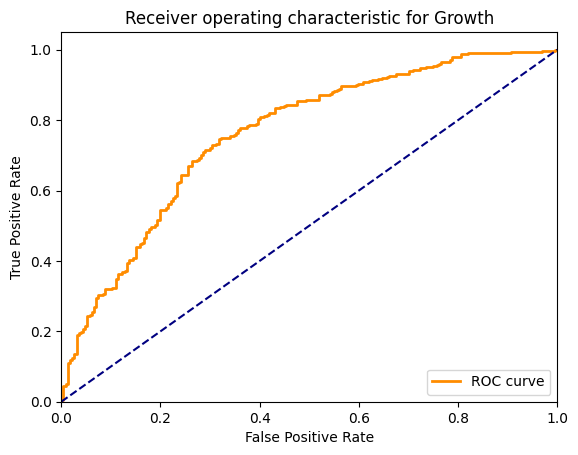

0.6925989071501186

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
growth_val = 0
growth_y_bin, growth_y_bin_per = y_bin(growth_val, Y_test, Y_pred_per)

g_fpr, g_tpr, g_thresholds = roc_curve(growth_y_bin, growth_y_bin_per)
plt_roc_curve(g_fpr, g_tpr, growth_val)
roc_auc_score(Y_test[:,growth_val], Y_pred[:,growth_val])


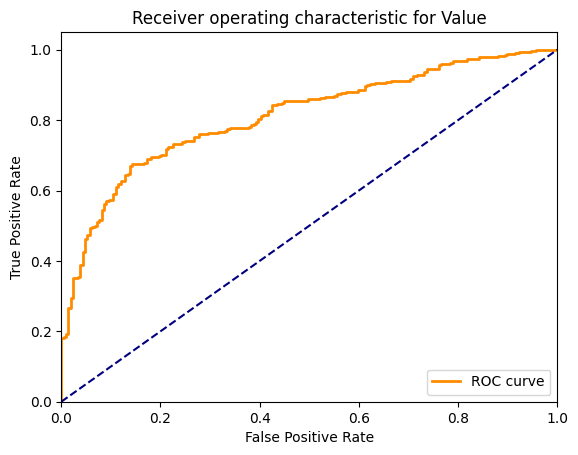

0.7546248318744074

In [27]:
value_val = 1
value_y_bin, value_y_bin_per = y_bin(value_val, Y_test, Y_pred_per)
v_fpr, v_tpr, v_thresholds = roc_curve(value_y_bin, value_y_bin_per)
plt_roc_curve(v_fpr, v_tpr, value_val)
roc_auc_score(Y_test[:,value_val], Y_pred[:,value_val])
